In [1]:
import argparse
import numpy as np
import pandas as pd
import sys
from scipy.sparse import load_npz, csr_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, brier_score_loss

In [37]:
from scipy.special import logit, expit
sigmoid = expit

def compute_metrics(y, y_pred):
    acc = accuracy_score(y, np.round(y_pred))
    auc = roc_auc_score(y, y_pred)
    nll = log_loss(y, y_pred, labels=[0,1])
    mse = brier_score_loss(y, y_pred)
    return acc, auc, nll, mse

default_bins = [(i*.05, (i+1)*.05) for i in range(20)]
def metrics_by_prob(df, y_pred, y, real_probs, bins=default_bins):
    mbp = []
    for low, high in bins:
        inds = np.nonzero((real_probs > low) & (real_probs <= high))[0]
        b_df, b_pred, b_y, b_probs = df.iloc[inds,:], y_pred[inds], y[inds], real_probs[inds]
        
        acc = accuracy_score(b_y, np.round(b_pred))
        # Skip AUC, it isn't well-defined these subsets of data
        nll = log_loss(b_y, b_pred,labels=[0,1])
        mse = brier_score_loss(b_y, b_pred)
        
        prob_stats = {"acc" : acc, "nll" : nll, "mse" : mse, "N" : len(b_y)}
        prob_stats.update(under_over_stats(b_df, b_pred, b_y, b_probs))
        mbp.append(((low,high), prob_stats))

    acc, auc, nll, mse = compute_metrics(y, y_pred)
    stats = {"acc" : acc, "auc" : auc, "nll" : nll, "mse" : mse, "metrics_by_prob" : mbp}
    print(f"TOTAL: ACC {acc:.4f} AUC {auc:.4f} MSE {mse:.4f} LOG LOSS: {nll:.4f}")
    return stats

def mean_nonzero_counts(counts):
    if(np.any(counts.index.isin([0]))):
        counts = counts.drop(0)    
    total = counts.sum()
    if(total == 0.0):
        return 0.0
    return (counts.index*counts).sum() / total
    

def prob_nonzero(counts):
    if(np.any(counts.index.isin([0]))):
        zero_count = counts.at[0]
    else:
        return 1.0
        
    total = counts.sum()
    if(total == 0.0):
        return 0.0
    return 1.0-(zero_count / total)

def under_over_stats(df, y_pred, y, real_probs, thresh=.85):
    df = df.copy()
    pPm = (y_pred >= thresh) # Predicted Positive mask
    Pm = (real_probs >= thresh) # Ground-Truth Positive mask
    pNm = (y_pred < thresh) # Predicted Negative mask
    Nm = (real_probs < thresh) # Ground-Truth Negative mask

    FPm = pPm & Nm # False Positive mask
    FNm = pNm & Pm # False Negative Mask

    df['over_prac'] = FNm
    df['under_prac'] = FPm
    over_by_stu_kc = df['over_prac'].groupby([df['user_id'], df['skill_id']]).sum() 
    under_by_stu_kc = df['under_prac'].groupby([df['user_id'], df['skill_id']]).sum() 
    avg_over_prac = over_by_stu_kc.mean()
    avg_under_prac = under_by_stu_kc.mean()

    over_counts = over_by_stu_kc.value_counts()
    under_counts = under_by_stu_kc.value_counts()


        
    #print(over_counts)
    #print("Rate(Over)", prob_nonzero(over_counts))
    #print("Rate(Under)", prob_nonzero(under_counts))
    #print("Avg(#Over Practice|Over)", mean_nonzero_counts(over_counts))
    #print("Avg(#Under Practice|Under)", mean_nonzero_counts(under_counts))
    #print(f"Avg Over Practice: {avg_over_prac:.3f} Avg Under Practice: {avg_under_prac:.3f}")

    stats = {
        "over_prob" : prob_nonzero(over_counts),
        "under_prob" : prob_nonzero(under_counts),
        "over_counts" : {k:v for k,v in zip(over_counts.index, over_counts)},
        "under_counts" : {k:v for k,v in zip(under_counts.index, under_counts)},
        "avg_over_mag" : mean_nonzero_counts(over_counts),
        "avg_under_mag" : mean_nonzero_counts(under_counts),
        "avg_over" : mean_nonzero_counts(over_counts),
        "avg_under" : mean_nonzero_counts(under_counts),
    }
    return stats
    

def mastery_residual(y_pred, y, real_probs, slopes, thresh=.85):
    # NOTE: This function is a legacy attempt to quantify over/under practice
    
    # NOTE: For now using absolute slopes... check that fitting is correct
    slopes = np.abs(slopes)
    
    pPm = (y_pred >= thresh) # Predict Positive mask
    Pm = (real_probs >= thresh) # Positive mask
    pNm = (y_pred < thresh) # Predict Negative mask
    Nm = (real_probs < thresh) # Negative mask

    FPm = pPm & Nm # True positive mask
    FNm = pNm & Pm # False positive Mask
    
    TP = np.sum(pPm & Pm) # True positives
    FP = np.sum(pPm & Nm) # False positives
    TN = np.sum(pNm & Nm) # True negatives
    FN = np.sum(pNm & Pm) # False negatives

    F1 = (2*TP) / (2*TP + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    acc = (TP + TN)/ (TP + TN + FP + FN)
    acc2 = accuracy_score(y_pred >= thresh, real_probs >= thresh)
    print(f"Mastery F1:{F1:.3f}, precision:{precision:3f} recall:{recall:.3f}, acc:{acc:.3f} acc2:{acc2:.3f}")

    # Need to clip the y_prediction so that it is never larger than thresh or less than 1-thresh 
    #  to ensure we don't get numerical stability issues from 
    clipped_y_pred = np.clip(y_pred, 1.0-thresh, thresh)
    #FP_resid = logit(clipped_y_pred[FPm]) - logit(real_probs[FPm])
    #FN_resid = logit(real_probs[FNm])-logit(clipped_y_pred[FNm])

    FP_resid = logit(thresh) - logit(real_probs[FPm])
    FN_resid = logit(real_probs[FNm]) - logit(thresh)
    
    #FP_resid = y_pred[FPm]-real_probs[FPm]
    #FN_resid = -(y_pred[FNm]-real_probs[FNm])
    #print(y_pred[FPm]-real_probs[FPm], FP_resid, np.argwhere(np.isnan(FP_resid)))
    

    #under_slope_aprox = sigmoid( (logit(.85) - logit(real_probs[FPm])) / slopes[FPm])-.5
    #over_slope_aprox = sigmoid( (logit(real_probs[FNm]) - logit(.85)) / slopes[FNm])-.5
    #print(under_slope_aprox)
    #print(over_slope_aprox)
    
    # Conditional i.e. given was FP or FN how many problems off is the estimate.
    cond_under_resid = np.mean(FP_resid/slopes[FPm])
    cond_over_resid = np.mean(FN_resid/slopes[FNm])

    # Expected under and over practice
    exp_under_resid = cond_under_resid * (FP / (TP+FP))
    exp_over_resid = cond_over_resid * (FN / (TN+FN))
    
    print(f"Residuals FP/TP: {np.mean(FP_resid):.3f}({FP}/{TP+FP}) {np.mean(FN_resid):.3f}({FN}/{TN+FN})")
    print(f"Conditional #Prob Under/Over: {cond_under_resid:.3f}({FP}/{TP+FP}) {cond_over_resid:.3f}({FN}/{TN+FN})")
    print(f"Expected #Prob Under/Over: {exp_under_resid:.3f} {exp_over_resid:.3f}")

    return FP_resid, FP_resid
    


dataset = "assistments09"
X_file = "X-sscwa.npz"

names_to_codes = {
    "BestLR" : "isicsctcwa",
    "PFA" : "sscwa"
}

from sklearn.model_selection import ShuffleSplit

splits = {}
def make_splits(dataset, n_splits=5, test_size=0.1):
    if(dataset not in splits):
        df = pd.read_csv(f'data/real/{dataset}/preprocessed_data.csv', sep="\t")
        unq_ids = df["user_id"].unique()
        splitter =ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=0)
        splits[dataset] = list(splitter.split(unq_ids))
    return splits[dataset]
    
def get_data_dir(dataset, sim_src):
    is_sim = sim_src != "real"
    inner_dir = f"sim-{sim_src}" if is_sim else "real"
    
    return f'data/{inner_dir}/{dataset}'
    
def load_data(dataset, sim_src="real", fold_num=0):
    is_sim = sim_src != "real"
    
    users_train, users_test = make_splits(dataset)[fold_num]
    dir = get_data_dir(dataset, sim_src)
    print("is_sim", is_sim, sim_src)
    filename = "preprocessed_data.csv" if not is_sim else f"{dataset}.csv"
    full_df = pd.read_csv(f"{get_data_dir(dataset, sim_src)}/{filename}", sep="\t")
    train_df = full_df[full_df["user_id"].isin(users_train)]
    test_df = full_df[full_df["user_id"].isin(users_test)]

    if(is_sim):
        train_probs = train_df['prob'].to_numpy()
        test_probs = test_df['prob'].to_numpy()
        return train_df, test_df, (train_probs, test_probs)
    else:
        return train_df, test_df, (None, None)
    
def load_lr_data(dataset, model_code="sscwa", sim_src="real", fold_num=0):
    model_code = names_to_codes.get(model_code, model_code)
    train_df,  test_df, true_probs = load_data(dataset, sim_src, fold_num)

    dir = get_data_dir(dataset, sim_src)
    X = csr_matrix(load_npz(f'{dir}/X-{model_code}.npz'))
    #if(is_sim):
        
    #else:
    #    X = csr_matrix(load_npz(f'data/{dataset}/X-{model_code}.npz'))
    
    user_ids = X[:, 0].toarray().flatten()
    users_train = train_df["user_id"].unique()
    users_test = test_df["user_id"].unique()
    train = X[np.where(np.isin(user_ids, users_train))]
    test = X[np.where(np.isin(user_ids, users_test))]
    #print(users_test)

    X_train, y_train = train[:, 5:], train[:, 3].toarray().flatten()
    X_test, y_test = test[:, 5:], test[:, 3].toarray().flatten()
    train_kc_ids = train_df["skill_id"].to_numpy()
    test_kc_ids = test_df["skill_id"].to_numpy()

    return (X_train, y_train), (X_test, y_test), true_probs, (train_kc_ids, test_kc_ids)
  
    

def fit_lr(X_train, y_train):
    model = LogisticRegression(solver="lbfgs", max_iter=1000)
    model.fit(X_train, y_train)
    return model

def eval_lr(model, data):
    X, y = data
    #test_df[f"LR_{features_suffix}"] = y_pred_test
    #test_df.to_csv(f'data/{args.dataset}/preprocessed_data_test.csv', sep="\t", index=False)
    y_pred = model.predict_proba(X)[:, 1]

    acc, auc, nll, mse = compute_metrics(y, y_pred)
    return auc

def load_fit_eval_lr(dataset, model_code="sscwa", sim_src="real", fold_num=0):
    train, test, probs, kc_ids = load_lr_data(dataset, model_code, sim_src, fold_num)
    model = fit_lr(*train)
    
    auc_train = eval_lr(model, train)
    auc_test = eval_lr(model, test)
    stats = {"auc" : auc_test}

    if(is_sim):
        #
        X_test, y_test = test
        y_pred = model.predict_proba(X_test)[:, 1]
        
        _,test_probs = probs
        _,test_kc_ids = kc_ids
        
        #params_df = pd.read_csv(f'simulation/model-values/pfa_kc_params.csv', sep=",")
        #params_df = params_df[params_df['Dataset'] == dataset]

        # This is very weird... there shouldn't be an S or F Intercept, just a slope
        #slopes_by_kc = params_df["S_Slope/KC"].to_numpy() + params_df["PFA_S_Intercept"].to_numpy()
        #test_slopes = slopes_by_kc[test_kc_ids]
        #print(slopes_by_kc.shape, test_kc_ids.shape, test_slopes.shape)
        #mastery_residual(y_pred, y_test, test_probs,  test_slopes)

        _, test_df, _ = load_data(dataset, sim_src, fold_num)
        
        stats.update(under_over_stats(test_df, y_pred, y_test, test_probs))
        stats.update(metrics_by_prob(test_df, y_pred, y_test, test_probs))

    return stats

#print(load_fit_eval_lr("assistments09", "PFA", sim_src="BestLR"))
#print(load_fit_eval_lr("assistments09", "BestLR", is_sim=True))

In [38]:
import argparse
import pandas as pd
from random import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score

import torch.nn as nn
from torch.optim import Adam
from torch.nn.utils.rnn import pad_sequence

from model_dkt2 import DKT2
from train_dkt2 import get_data, prepare_batches, compute_auc, compute_loss, train
from utils import *
batch_size=64

def train_deep(train_df, test_df, hid_size=200, embed_size=200, num_hid_layers=1, drop_prob=.5, _batch_size=64,
              log_dir='runs/dkt', savedir='save/dkt',
              lr=1e-2, num_epochs=100, seed=0):
    global batch_size
    batch_size = _batch_size

    set_random_seeds(seed)


    #load_data(dataset,)
    #train_df = pd.read_csv(os.path.join('data', dataset, 'preprocessed_data_train.csv'), sep="\t")
    #test_df = pd.read_csv(os.path.join('data', dataset, 'preprocessed_data_test.csv'), sep="\t")

    train_data, val_data = get_data(train_df, train_split=0.8)


    max_item = max(int(train_df["item_id"].max()), int(test_df["item_id"].max()))
    max_skill = max(int(train_df["skill_id"].max()), int(test_df["skill_id"].max()))

    model = DKT2(max_item, max_skill, hid_size,
                 embed_size, num_hid_layers, drop_prob).cuda()
    
    optimizer = Adam(model.parameters(), lr=lr)

    # Reduce batch size until it fits on GPU
    while True:
        try:
            # Train
            param_str = f"{dataset}"
            logger = Logger(os.path.join(log_dir, param_str))
            saver = Saver(savedir, param_str)
            train(train_data, val_data, model, optimizer, logger, saver, num_epochs, batch_size)
            break
        except RuntimeError as e:
            print(e)
            batch_size = batch_size // 2
            print(f'Batch does not fit on gpu, reducing size to {batch_size}')
    
    logger.close()
    return model

    
def eval_deep(model, test_df, savedir='save/dkt'):
    if(isinstance(model, str)):
        saver = Saver(savedir, model)
        model = saver.load()
    test_data, _ = get_data(test_df, train_split=1.0, randomize=False)
    test_batches = prepare_batches(test_data, batch_size, randomize=False)
    test_preds = np.empty(0)
    test_skill_preds = np.empty(0)

    # Predict on test set
    model.eval()
    for item_inputs, skill_inputs, label_inputs, item_ids, skill_ids, labels in test_batches:
        print(item_ids.unique())
        with torch.no_grad():
            item_inputs = item_inputs.cuda()
            skill_inputs = skill_inputs.cuda()
            label_inputs = label_inputs.cuda()
            item_ids = item_ids.cuda()
            skill_ids = skill_ids.cuda()

            # Make the per-item prediction
            preds = model(item_inputs, skill_inputs, label_inputs, item_ids, skill_ids)
            preds = torch.sigmoid(preds[labels >= 0]).cpu().numpy()
            test_preds = np.concatenate([test_preds, preds])

            # Make a per-skill prediction (zero-out the item one-hot)
            _item_ids = (-torch.ones_like(item_ids)).cuda()
            skill_preds = model(item_inputs, skill_inputs, label_inputs, _item_ids, skill_ids)
            skill_preds = torch.sigmoid(skill_preds[labels >= 0]).cpu().numpy()
            test_skill_preds = np.concatenate([test_skill_preds, skill_preds])

    return test_preds, test_skill_preds
    

def _load_fit_eval_deep(dataset, sim_src="real", q=None):
    #try:
        is_sim = sim_src != "real"
        train_df, test_df, true_probs = load_data(dataset, sim_src)
        model = train_deep(train_df, test_df)
        torch.cuda.empty_cache() 
        #auc_train = eval_deep(model, train_df)
        test_item_preds, test_skill_preds = eval_deep(model, test_df)
        item_stats, skill_stats = {}, {}
        if(is_sim):
            _, test_probs = true_probs
            y_test = test_df["correct"].to_numpy()
    
            train_kc_ids = train_df["skill_id"].to_numpy()
            test_kc_ids = test_df["skill_id"].to_numpy()
            
            # This is very weird... there shouldn't be an S or F Intercept, just a slope
            #params_df = pd.read_csv(f'simulation/model-values/pfa_kc_params.csv', sep=",")
            #params_df = params_df[params_df['Dataset'] == dataset]
            #slopes_by_kc = params_df["S_Slope/KC"].to_numpy() + params_df["PFA_S_Intercept"].to_numpy()
            #test_slopes = slopes_by_kc[test_kc_ids]
            
            #mastery_residual(test_preds, y_test, test_probs, test_slopes)
            item_stats.update(under_over_stats(test_df, test_item_preds, y_test, test_probs))
            item_stats.update(metrics_by_prob(test_df, test_item_preds, y_test, test_probs))

            skill_stats.update(under_over_stats(test_df, test_skill_preds, y_test, test_probs))
            skill_stats.update(metrics_by_prob(test_df, test_skill_preds, y_test, test_probs))
    
        else:
            #train_preds = eval_deep(model, train_df)
            
            acc, auc, nll, mse = compute_metrics(test_df["correct"], test_item_preds)
            item_stats = {"acc" : acc, "auc" : auc, "nll" : nll, "mse" : mse}

            acc, auc, nll, mse = compute_metrics(test_df["correct"], test_skill_preds)
            skill_stats = {"acc" : acc, "auc" : auc, "nll" : nll, "mse" : mse}
        #train_preds = roc_auc_score(train_df["correct"], train_preds)
        #test_preds = roc_auc_score(test_df["correct"], test_preds)
        if(q):
            q.put((item_stats, skill_stats))
            sys.exit(0)
    #except Exception as e:
    #    print(e)
        #sys.exit(1)
    
    #return stats

import multiprocessing as mp
import time
def load_fit_eval_deep(dataset, is_sim=False):

    # Use a seperate process so that the GPU memory is definitely freed when finished
    q = mp.Queue()
    p = mp.Process(target=_load_fit_eval_deep, args=(dataset, is_sim, q))
    p.start()

    
    while True:
        p.join(1) # Block for 1 second
        if(p.exitcode == 0):
            break
        # Terminate if there was an error
        if(p.exitcode is not None and p.exitcode != 0):
            p.terminate()
            break
    
    stats, skill_stats = q.get()
    return stats, skill_stats

    



In [39]:
import json
all_stats = {}
def get_cond_statspath(dataset, sim_src, model, item_stats, kind):
    k = "i" if kind == "item" else "s"
    file_path = f"model_stat_store/{dataset}({sim_src})-{model}-{k}.json"
    return file_path
    
def set_stats(dataset, sim_src, model, item_stats, skill_stats=None):
    # Save item stats
    all_stats[(dataset, sim_src, model, 'item')] = item_stats
    with open(get_cond_statspath(dataset, sim_src, model, item_stats, 'item'), 'w') as f:
        json.dump(item_stats, f)

    # Save skill stats if available
    if(skill_stats):
        all_stats[(dataset, sim_src, model, 'skill')] = skill_stats
        with open(get_cond_statspath(dataset, sim_src, model, skill_stats, 'skill'), 'w') as f:
            json.dump(skill_stats, f)

def get_stats(dataset, sim_src, model, kind='item'):
    tup = (dataset, sim_src, model, kind)
    if(tup in all_stats):
        return all_stats[tup]
        
    with open(get_cond_statspath(dataset, sim_src, model, item_stats, kind), 'r') as f:
        stats = json.load(f)
    return stats


In [47]:
for dataset in ['spanish']:#['assistments09', 'assistments15', 'bridge_algebra06',  'assistments17',  'statics', 'algebra05']:
    for sim_src in ["real", "BestLR"]:
        #try:
        is_sim = sim_src != "real"
        set_stats(dataset, sim_src, "DKT", *load_fit_eval_deep(dataset, sim_src))
        set_stats(dataset, sim_src, "PFA", load_fit_eval_lr(dataset, "PFA", sim_src))
        set_stats(dataset, sim_src, "BestLR", load_fit_eval_lr(dataset, "BestLR", sim_src))
        

is_sim False real
CUDA out of memory. Tried to allocate 2.22 GiB (GPU 0; 5.79 GiB total capacity; 4.04 GiB already allocated; 838.19 MiB free; 4.27 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 32
CUDA out of memory. Tried to allocate 692.00 MiB (GPU 0; 5.79 GiB total capacity; 3.59 GiB already allocated; 66.19 MiB free; 4.91 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Batch does not fit on gpu, reducing size to 16
Step 9, {'loss/train': 0.49749140606986153, 'auc/train': 0.7222853244985749, 'auc/val': 0.7737706299609513}
Step 18, {'loss/train': 0.45892252524693805, 'auc/train': 0.7845362946930424, 'auc/val': 0.7758611321008827}
Step 20, {'l

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


is_sim True BestLR
TOTAL: ACC 0.8389 AUC 0.8503 MSE 0.1145 LOG LOSS: 0.3656


In [51]:
from itertools import product
for sim_src in ["real", "BestLR"]:
    is_sim = sim_src != "real"
    if(is_sim):
        df = pd.DataFrame(columns=["Dataset", "Model", "Acc", "AUC", "Avg Over+Under", "Avg Over", "Avg Under", ])
    else:
        df = pd.DataFrame(columns=["Dataset", "Model", "Acc", "AUC"])
        
    for i, (dataset, model) in enumerate(product(['assistments09', 'assistments15', 'assistments17', 'bridge_algebra06', 'statics', 'algebra05', 'spanish'],
                              ["PFA", "BestLR", ("DKT","item")])):#, ("DKT", "skill")])):

        kind = "item"
        
        if(isinstance(model, tuple)):
            model, kind = model
        k = "" if kind == "item" else "-sk"
        try:
            stats = get_stats(dataset, sim_src, model, kind)
        except:
            continue
        #print(dataset, model, stats)
        if(is_sim):
            df.loc[i] = [dataset, f"{model}{k}", stats.get('acc'), stats['auc'], stats['avg_over'] + stats['avg_under'], stats['avg_over'], stats['avg_under']]
        else:
            df.loc[i] = [dataset, f"{model}{k}", stats.get('acc'), stats['auc']]
    print(f"\n Simulation Data (from {sim_src}):" if is_sim else "\n Real Data")
    pd.set_option('display.precision', 3)
    print(df)
    


 Real Data
             Dataset   Model    Acc    AUC
0      assistments09     PFA    NaN  0.712
1      assistments09  BestLR    NaN  0.773
2      assistments09     DKT  0.724  0.748
3      assistments15     PFA    NaN  0.690
4      assistments15  BestLR    NaN  0.700
5      assistments15     DKT  0.744  0.721
6      assistments17     PFA    NaN  0.625
7      assistments17  BestLR    NaN  0.714
8      assistments17     DKT  0.715  0.770
9   bridge_algebra06     PFA    NaN  0.753
10  bridge_algebra06  BestLR    NaN  0.799
11  bridge_algebra06     DKT  0.846  0.762
12           statics     PFA    NaN  0.683
13           statics  BestLR    NaN  0.816
14           statics     DKT  0.795  0.819
15         algebra05     PFA    NaN  0.755
16         algebra05  BestLR    NaN  0.820
17         algebra05     DKT  0.798  0.771
18           spanish     PFA    NaN  0.848
19           spanish  BestLR    NaN  0.861
20           spanish     DKT  0.840  0.839

 Simulation Data (from BestLR):
         

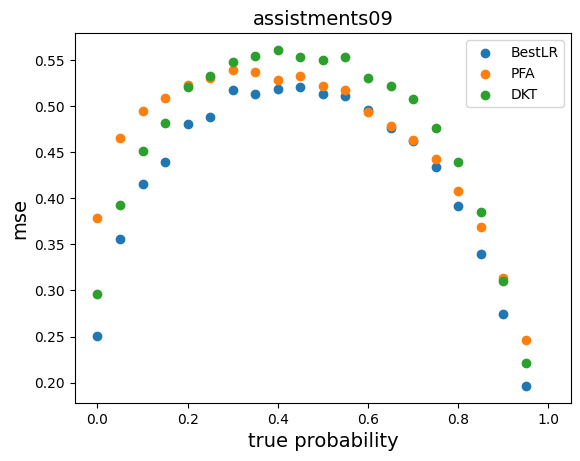

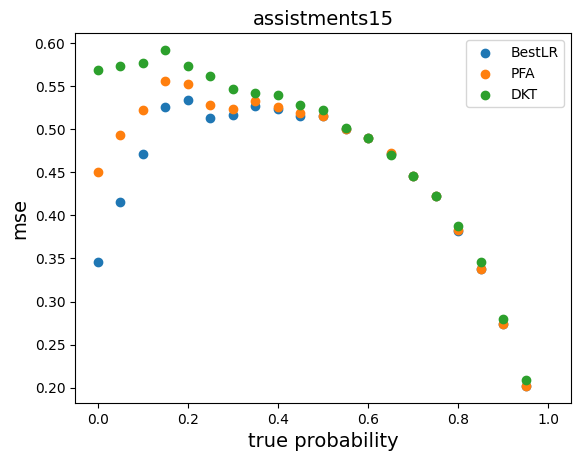

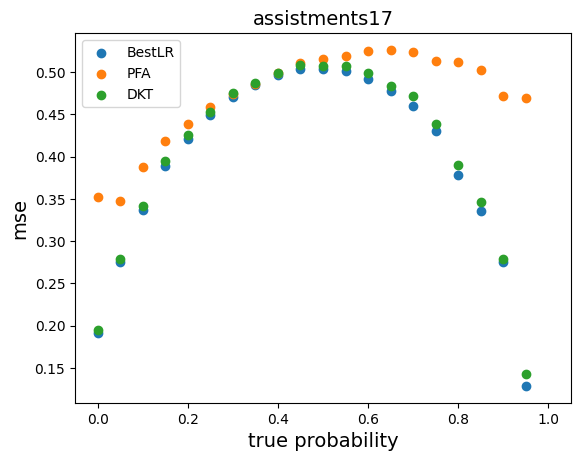

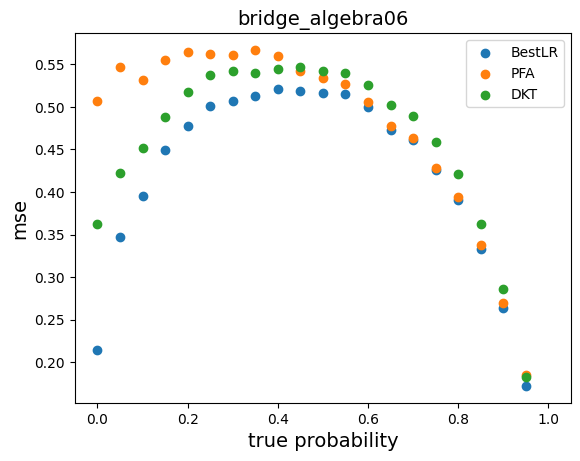

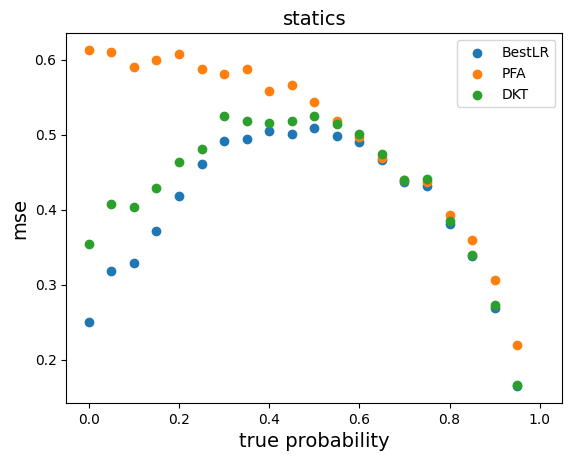

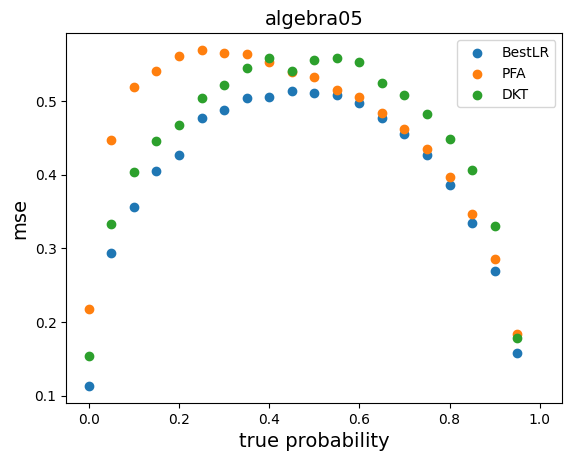

In [46]:
import matplotlib.pyplot as plt

def plot_metrics_by_prob(dataset, sim_src, models, metric="mse"):
    for model in models:
        kind = "item"
        if(isinstance(model, tuple)):
            model, kind = model
        stats = get_stats(dataset, sim_src, model, kind)
        bins, stats_by_prob = zip(*stats["metrics_by_prob"])
        metric_vals = [np.sqrt(x[metric]) for x in stats_by_prob]
        plt.scatter([x[0] for x in bins], metric_vals, label=model)
    plt.ylabel(metric, fontsize=14)
    plt.xlabel("true probability",fontsize=14)
    plt.title(dataset,fontsize=14)
    plt.xlim(-.05, 1.05)
    plt.legend()
    plt.show()



plot_metrics_by_prob('assistments09', "BestLR",  ["BestLR", "PFA", "DKT"])
plot_metrics_by_prob('assistments15', "BestLR", ["BestLR", "PFA", "DKT"])
plot_metrics_by_prob('assistments17', "BestLR", ["BestLR", "PFA", "DKT"])
plot_metrics_by_prob('bridge_algebra06', "BestLR",  ["BestLR", "PFA", "DKT"])
plot_metrics_by_prob('statics', "BestLR",  ["BestLR", "PFA", "DKT"])
plot_metrics_by_prob('algebra05', "BestLR",  ["BestLR", "PFA", "DKT"])
plot_metrics_by_prob('spanish', "BestLR",  ["BestLR", "PFA", "DKT"])




In [137]:
auc_train, auc_test = load_fit_eval_deep("assistments09")
print(f"DKT on REAL (AUC) Train: {auc_train} Test: {auc_test}")

Step 20, {'loss/train': 0.5930243015289307, 'auc/train': 0.6723344037953826}
Step 20, {'auc/val': 0.74285085518458}
Step 40, {'loss/train': 0.5423457533121109, 'auc/train': 0.7517106827942353}
Step 40, {'auc/val': 0.7622018025258173}
Step 60, {'loss/train': 0.5064413413405419, 'auc/train': 0.7953357869098212}
Step 60, {'auc/val': 0.7701891388040335}
Step 80, {'loss/train': 0.46225973069667814, 'auc/train': 0.8337672252119626}
Step 80, {'auc/val': 0.7719971352286149}
Step 100, {'loss/train': 0.42171138525009155, 'auc/train': 0.8665061370366838}
Step 100, {'auc/val': 0.7655686859590765}
Step 120, {'loss/train': 0.38699825555086137, 'auc/train': 0.8886522511324202}
Step 120, {'auc/val': 0.7557986549733957}
Step 140, {'loss/train': 0.3505245134234428, 'auc/train': 0.91012155493646}
Step 140, {'auc/val': 0.7469818845017311}
Step 160, {'loss/train': 0.31534802466630935, 'auc/train': 0.9283812214010062}
Step 160, {'auc/val': 0.7354199269089058}
Step 180, {'loss/train': 0.2870065078139305, 'au

In [6]:
stats = load_fit_eval_deep("assistments09", is_sim=True)
print(stats)

Step 20, {'loss/train': 0.5930243015289307, 'auc/train': 0.6723344037953826}
Step 20, {'auc/val': 0.74285085518458}
Step 40, {'loss/train': 0.5423457533121109, 'auc/train': 0.7517106827942353}
Step 40, {'auc/val': 0.7622018025258173}
Step 60, {'loss/train': 0.5064413413405419, 'auc/train': 0.7953357869098212}
Step 60, {'auc/val': 0.7701891388040335}
Step 80, {'loss/train': 0.46225973069667814, 'auc/train': 0.8337672252119626}
Step 80, {'auc/val': 0.7719971352286149}
Step 100, {'loss/train': 0.42171138525009155, 'auc/train': 0.8665061370366838}
Step 100, {'auc/val': 0.7655686859590765}
Step 120, {'loss/train': 0.38699825555086137, 'auc/train': 0.8886522511324202}
Step 120, {'auc/val': 0.7557986549733957}
Step 140, {'loss/train': 0.3505245134234428, 'auc/train': 0.91012155493646}
Step 140, {'auc/val': 0.7469818845017311}
Step 160, {'loss/train': 0.31534802466630935, 'auc/train': 0.9283812214010062}
Step 160, {'auc/val': 0.7354199269089058}
Step 180, {'loss/train': 0.2870065078139305, 'au

In [97]:
auc_train, auc_test = load_fit_eval_lr("assistments09", "BestLR")
print(f"BESTLR on REAL (AUC) Train: {auc_train} Test: {auc_test}")

/home/danny/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


BESTLR on REAL (AUC) Train: 0.8229472125317272 Test: 0.7666073708657459


In [ ]:
auc_train, auc_test = load_fit_eval_lr("assistments09", "BestLR", is_sim=True)
print(f"BESTLR on SIM (AUC) Train: {auc_train} Test: {auc_test}")

In [99]:
auc_train, auc_test = load_fit_eval_lr("assistments09", "PFA")
print(f"PFA on REAL (AUC) Train: {auc_train} Test: {auc_test}")

PFA on REAL (AUC) Train: 0.7212668034833476 Test: 0.7085018645511809


In [100]:
auc_train, auc_test = load_fit_eval_lr("assistments09", "PFA", is_sim=True)
print(f"PFA on SIM (AUC) Train: {auc_train} Test: {auc_test}")

PFA on SIM (AUC) Train: 0.6926758204839265 Test: 0.6834338525139869


        user_id  item_id  timestamp  correct  skill_id
0             0    12661          0        0       143
1             0    12685          0        1       143
2             0    12678          0        0       143
3             0    12697          0        0       143
4             0    12698          0        0       143
...         ...      ...        ...      ...       ...
278331     3113      630          0        1        82
278332     3113      624          0        1        82
278333     3113      616          0        1        82
278334     3113      980          0        1        24
278335     3113     5992          0        1       100

[278336 rows x 5 columns]


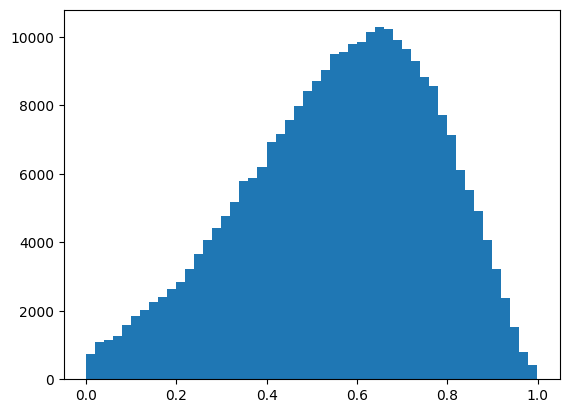

In [69]:
dataset = "assistments09"
X_file = "X-sscwa.npz"
    
X = csr_matrix(load_npz(f'data/{dataset}/{X_file}'))
#df = pd.read_csv(f'data/{dataset}/preprocessed_data.csv', sep="\t")
sim_df = pd.read_csv(f'simulation/simulated-data/{dataset}/{dataset}.csv', sep="\t")
print(df)

import matplotlib.pyplot as plt
import numpy as np


#plt.hist(df['prob'], bins=50)
plt.hist(sim_df['prob'], bins=50)
plt.show()
